### IN4080 2019, Mandatory assignment 2, part A

In [12]:
import nltk
import random
import numpy as np
import scipy as sp
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools


In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Ex 1 First classifier

In [14]:
def createSets(movie_dev):
    X = []
    y = []
    for movie in movie_dev:
        X.append(movie[0])
        y.append(movie[1])

    label_encoder = LabelEncoder()
    y_labels = label_encoder.fit_transform(y)
    return X, y

In [15]:
raw_movie_docs = [(movie_reviews.raw(fileid), category) for
                    category in movie_reviews.categories() for fileid in
                    movie_reviews.fileids(category)]

In [16]:
random.seed(2920)
random.shuffle(raw_movie_docs)
movie_test = raw_movie_docs[:200]
movie_dev = raw_movie_docs[200:]

In [17]:
X, labels = createSets(movie_dev)

In [18]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, labels, test_size=0.125, random_state=42)

In [19]:
v = CountVectorizer()
v.fit(X_train)

X_train_vectors = v.transform(X_train)
X_val_vectors = v.transform(X_validation)

In [20]:
clf = MultinomialNB()
clf.fit(X_train_vectors, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
pred = clf.predict(X_val_vectors)

In [22]:
clf.score(X_val_vectors, Y_validation)

0.8222222222222222

In [23]:
f1 = f1_score(pred, Y_validation, labels=['neg','pos'], average='micro')
cm = confusion_matrix(Y_validation, pred)

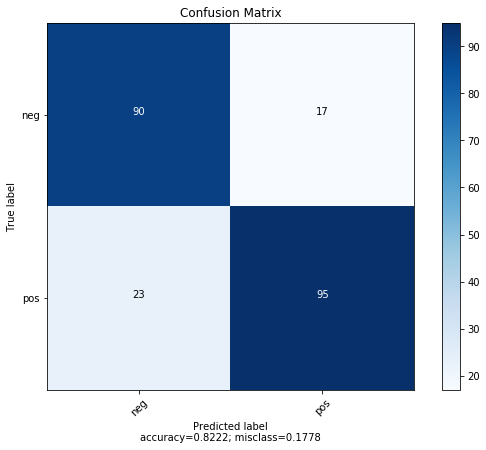

In [24]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['neg', 'pos'],
                      title        = "Confusion Matrix")

In [25]:
def multi_nb_exp(X, y):
    text_clf = Pipeline([
                         ('vect', CountVectorizer()),
                         ('clf', MultinomialNB())])
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.125, random_state=42)
    text_clf.fit(X_train, Y_train)
    predicted = text_clf.predict(X_validation)
    acc = text_clf.score(X_validation, Y_validation) 
    return acc, predicted 

In [26]:
%%time
(acc, pred) = multi_nb_exp(X, labels)
print(acc)

0.8222222222222222
CPU times: user 1.22 s, sys: 5.54 ms, total: 1.22 s
Wall time: 1.02 s


In [27]:
def n_fold(clf, x, y, n=9):
    acc = cross_val_score(clf, x, y, cv=n, n_jobs=-1) # same as using K-fold with splits.
    return acc

text_clf = Pipeline([
                     ('vect', CountVectorizer()),
                     ('clf', MultinomialNB())])

acc = n_fold(text_clf, X, labels)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",acc.mean() * 100)

Accuracy of Model with Cross Validation is: 81.33396807142401


In [28]:
def scores(model, X_validation, Y_validation):
    predicted = model.predict(X_validation)
    precision = precision_score(Y_validation, predicted)
    recall = recall_score(Y_validation, predicted)
    f1 = f1_score(Y_validation, predicted)
    print("Precision of Modelis:",precision * 100)
    print("Recall of Model is:",recall * 100)
    print("F1 score of Model is:",f1 * 100)
    return f1, precision, recall

### 1.2 Ex 2 Parameters of the vectorizer 
[False, True] and ngram_range vary over [[1,1], [1,2], [1,3]].
Run the experiment with 9-fold cross-validation and report the accuracy with the 6 different settings.

In [30]:
def arg_experiment():
    k = [True, False]
    ngram_range_results = []
    ngram_range = [(1,1), (1,2),(1,3)]

    results = []
    for binary in k:
        liste = []
        for ngram in ngram_range:
            count_experiment_clf = Pipeline([
                             ('vect', CountVectorizer(ngram_range=ngram, binary=binary)),
                             ('clf', MultinomialNB())])
            acc = cross_val_score(count_experiment_clf, X, labels, cv=9, n_jobs=-1)

            liste.append(acc.mean() * 100)
        ngram_range_results.append(liste)

    df = pd.DataFrame(ngram_range_results, index=['True','False'], columns=['(1,1)','(1,2)','(1,3)'])
    return df
df = arg_experiment()
df

,"(1,1)","(1,2)","(1,3)"
True,82.337017,85.615942,85.113711
False,81.333968,83.225367,82.557301


## Ex 3  Logistic Regression

In [18]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

log_reg_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('clf', LogisticRegression())])

acc = cross_val_score(log_reg_clf, X, labels, cv=9, n_jobs=-1)
print("Accuracy of Model with Cross Validation is:",acc.mean() * 100)

Accuracy of Model with Cross Validation is: 83.33925570361482


In [19]:
def logistic_reg():
    from warnings import simplefilter
    # ignore all future warnings
    simplefilter(action='ignore', category=FutureWarning)

    log_reg_clf = Pipeline([
         ('vect', CountVectorizer()),
         ('clf', LogisticRegression())])

    acc = cross_val_score(log_reg_clf, X, labels, cv=9, n_jobs=-1)
    return acc

acc = logistic_reg()
print("Accuracy of Model with Cross Validation is:",acc.mean() * 100)

Accuracy of Model with Cross Validation is: 83.33925570361482


### Ex 4 The Bernoulli model 

In [20]:
all_words = nltk.FreqDist(w.lower() for w in movie_reviews.words())
def document_features(document,n):
    word_features = list(all_words)[:n]
    document_words = set(document)
    features = {}
    for word in word_features:
        features[word] = (word in document_words)
    return features

In [21]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)

In [22]:
feature_set = [(document_features(doc,2000), category) for (doc, category) in documents]

In [23]:
movie_feat_test = feature_set[:200]
movie_feat_dev = feature_set[200:]

x, y = createSets(movie_feat_dev)

In [24]:
ber_clf = Pipeline([
     ('dict_vect', DictVectorizer()),
     ('clf', BernoulliNB())])

In [25]:
acc = cross_val_score(ber_clf, x, y, cv=9, n_jobs=-1) 
print("Accuracy of Model with Cross Validation is:",acc.mean() * 100)

Accuracy of Model with Cross Validation is: 79.71621096082957


### Ex 5 Logistic regression

In [52]:
def freq_experiment(pipeline, n):
    feat_set = [(document_features(doc,n), category) for (doc, category) in documents]
    movie_feat_test = feat_set[:200]
    dev = feat_set[200:]
    x, y = createSets(dev)
    acc = cross_val_score(pipeline, x, y, cv=9, n_jobs=-1) 
    return acc

In [60]:
def log_clf_freq_experiment(n):
    log_clf = Pipeline([
         ('vect', DictVectorizer()),
         ('clf', LogisticRegression())])
    log_clf_freq = []
    for i in n:
        acc = freq_experiment(log_clf, i)
        log_clf_freq.append(acc)
    return log_clf_freq

def ber_clf_experiment(n):
    ber_clf = Pipeline([
     ('dict_vect', DictVectorizer()),
     ('clf', BernoulliNB())])
    ber_clf_freq = []
    for i in n:
        acc = freq_experiment(ber_clf, i)
        ber_clf_freq.append(acc)
    return ber_clf_freq

In [65]:
def ex5_partb():
    n = [1000, 2000, 3000, 4000, 5000]
    accs_log = log_clf_freq_experiment(n)
    accs_ber = ber_clf_experiment(n)
    dict1 = {}
    for i in range(len(accs_ber)):
        dict1[str(n[i])] = [accs_log[i].mean()*100, accs_ber[i].mean()*100]

    df = pd.DataFrame(dict1) 
    df.index = ['LogisticRegression', 'BernoulliNB'] 
    return df
#df = ex5_partb()
#df

,1000,2000
LogisticRegression,76.376694,78.876468
BernoulliNB,77.782275,79.716211


### Bringing on the test set and the best model
Exercise 6

In [163]:
log_reg_clf = Pipeline([
     ('vect', TfidfVectorizer()), # using term frequency - inverted document frequency isted of count vector 
     ('clf', LogisticRegression())])

In [164]:
movie_test_cp = movie_test

In [165]:
y = []
X_test = []
for movie in movie_test_cp:
    X_test.append(movie[0])
    y.append(movie[1])

label_encoder = LabelEncoder()
y_test_labels = label_encoder.fit_transform(y)



In [166]:
X_dev, y_labels_dev = createSets(movie_dev)
log_reg_clf.fit(X_dev, y_labels_dev)
pred_test = log_reg_clf.predict(X_test)
pred_test = label_encoder.fit_transform(pred_test)

In [167]:
precision = precision_score(y_test_labels, pred_test)
recall = recall_score(y_test_labels, pred_test)
f1 = f1_score(y_test_labels, pred_test)
tn, fp, fn, tp = confusion_matrix(y_test_labels, pred_test).ravel()
acc = ((tp + tn) / (tp+tn+fp+fn))
print("Accuracy of Model is:",acc*100)
print("Precision of Model is:",precision * 100)
print("Recall of Model is:",recall * 100)
print("F1 score of Model is:",f1 * 100)


Accuracy of Model is: 83.0
Precision of Model is: 83.33333333333334
Recall of Model is: 83.33333333333334
F1 score of Model is: 83.33333333333334


In [154]:
cm = confusion_matrix(y_test_labels, pred_test)

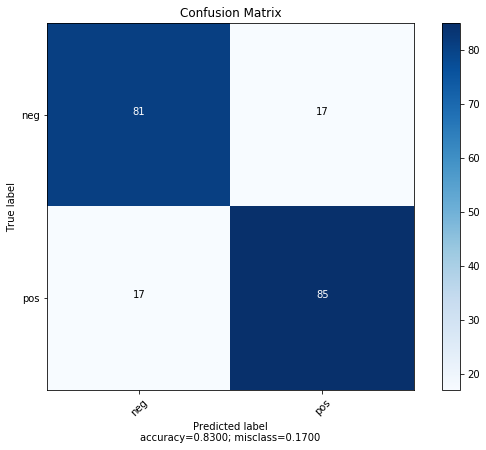

In [168]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['neg', 'pos'],
                      title        = "Confusion Matrix")